In [16]:
%pip install pycaret

Note: you may need to restart the kernel to use updated packages.


In [17]:
from pycaret.classification import *
from pycaret.regression import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [18]:
pm_data = pd.read_csv("clean_data\\cleaned_data.csv")
pm_data["timestamp"] = pd.to_datetime(pm_data["timestamp"])
print(pm_data)

               timestamp   humidity     pm_2_5  temperature
0    2024-11-19 23:00:00  99.688333  23.166667    28.658334
1    2024-11-20 00:00:00  99.703334  25.500000    28.520000
2    2024-11-20 01:00:00  99.798335  24.866667    28.443333
3    2024-11-20 02:00:00  99.900002  16.883333    28.346666
4    2024-11-20 03:00:00  99.875002   9.766667    28.126666
...                  ...        ...        ...          ...
1995 2025-02-11 08:00:00  99.900002  32.583333    24.108333
1996 2025-02-11 09:00:00  99.900002  39.872727    25.109091
1997 2025-02-11 10:00:00  99.832760  22.327586    26.774138
1998 2025-02-11 11:00:00  96.426316  21.912281    28.028070
1999 2025-02-11 11:15:57  94.192308  21.571429    28.792857

[2000 rows x 4 columns]


In [19]:
s = setup(pm_data, target = 'pm_2_5', session_id = 123,date_features=["timestamp"],normalize=True)

,Description,Value
0,Session id,123
1,Target,pm_2_5
2,Target type,Regression
3,Original data shape,"(2000, 4)"
4,Transformed data shape,"(2000, 6)"
5,Transformed train set shape,"(1400, 6)"
6,Transformed test set shape,"(600, 6)"
7,Numeric features,2
8,Date features,1
9,Preprocess,True


In [20]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,4.7503,60.5331,7.4657,0.6949,0.4012,0.4343,0.0990
rf,Random Forest Regressor,4.2900,61.0475,7.5755,0.6780,0.3936,0.4022,0.1340
gbr,Gradient Boosting Regressor,5.5429,69.4953,8.1247,0.6344,0.4731,0.5990,0.0680
et,Extra Trees Regressor,4.4466,76.7374,8.3987,0.5908,0.4224,0.4021,0.0980
dt,Decision Tree Regressor,4.8494,82.3268,8.8115,0.5636,0.4664,0.4178,0.0230
knn,K Neighbors Regressor,6.0954,87.6415,9.1409,0.5387,0.4665,0.5334,0.0290
ada,AdaBoost Regressor,8.6227,125.2050,11.0632,0.3187,0.6923,1.1841,0.0530
ridge,Ridge Regression,8.8110,132.3221,11.3699,0.2822,0.6615,1.0229,0.0220
lar,Least Angle Regression,8.8112,132.3752,11.3714,0.2821,0.6595,1.0185,0.0230
lr,Linear Regression,8.8112,132.3752,11.3714,0.2821,0.6595,1.0185,1.0560


In [21]:
best_model = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,5.0123,50.9343,7.1368,0.6504,0.4359,0.4440
1,4.6085,44.4951,6.6705,0.7242,0.4375,0.4853
2,5.4226,183.1814,13.5345,0.4620,0.4614,0.5133
3,4.2688,33.7600,5.8103,0.7860,0.3266,0.3246
4,4.6009,39.5152,6.2861,0.7084,0.3815,0.3952
5,4.9326,77.1615,8.7842,0.6616,0.3616,0.3205
6,4.1353,31.7936,5.6386,0.7881,0.3335,0.3194
7,4.8866,44.2906,6.6551,0.7580,0.4454,0.5790
8,4.8539,45.5148,6.7465,0.7125,0.3840,0.3982


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [22]:
best_model_tune = tune_model(best_model)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,21:46:45
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,5.1554,52.8048,7.2667,0.6376,0.4506,0.4437
1,4.9796,54.2832,7.3677,0.6635,0.4691,0.5117
2,5.3827,179.4604,13.3963,0.4729,0.4767,0.5531
3,3.7863,27.1282,5.2085,0.8280,0.3012,0.2618
4,4.8480,64.6658,8.0415,0.5228,0.4120,0.3881
5,5.0037,62.4789,7.9044,0.7260,0.4123,0.3443
6,3.9806,32.6733,5.7161,0.7822,0.3160,0.2971
7,5.1365,55.2054,7.4300,0.6983,0.4742,0.6196
8,4.8473,53.7388,7.3307,0.6606,0.4180,0.4345


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [23]:
ensem_best_model = ensemble_model(best_model_tune, n_estimators = 50)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.9084,48.1843,6.9415,0.6693,0.4271,0.4536
1,4.5086,43.2236,6.5745,0.7320,0.4329,0.4974
2,5.4714,179.7813,13.4083,0.4719,0.4583,0.5234
3,4.1944,32.0663,5.6627,0.7967,0.3210,0.3239
4,4.4991,37.3473,6.1112,0.7244,0.3742,0.3861
5,4.9136,77.6113,8.8097,0.6596,0.3598,0.3242
6,4.0319,30.4417,5.5174,0.7971,0.3261,0.3120
7,5.0719,47.6201,6.9007,0.7398,0.4596,0.6105
8,4.7320,44.5754,6.6765,0.7185,0.3779,0.3894


In [24]:
now = pd.Timestamp.now()
startdate = now.date()
enddate = startdate + pd.DateOffset(days=7)
next_week = pd.date_range(start=startdate, end=enddate, freq='D')

In [25]:
next_data = pd.DataFrame({'timestamp': next_week})
next_data['pm_2_5'] = pm_data['pm_2_5'].mean().round(2)
next_data['humidity'] = pm_data['humidity'].mean().round(2)
next_data['temperature'] = pm_data['temperature'].mean().round(2)


In [26]:
predict = predict_model(ensem_best_model, data=next_data)
data_plot = pd.DataFrame(predict, columns=['timestamp', 'prediction_label'])
data_plot["prediction_label"] = data_plot["prediction_label"].round(2)
data_plot

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,4.2237,21.5449,4.6416,0.0000,0.1870,0.1994


,timestamp,prediction_label
0,2025-03-14,27.55
1,2025-03-15,27.50
2,2025-03-16,22.45
3,2025-03-17,22.49
4,2025-03-18,25.79
5,2025-03-19,27.14
6,2025-03-20,25.41
7,2025-03-21,24.90


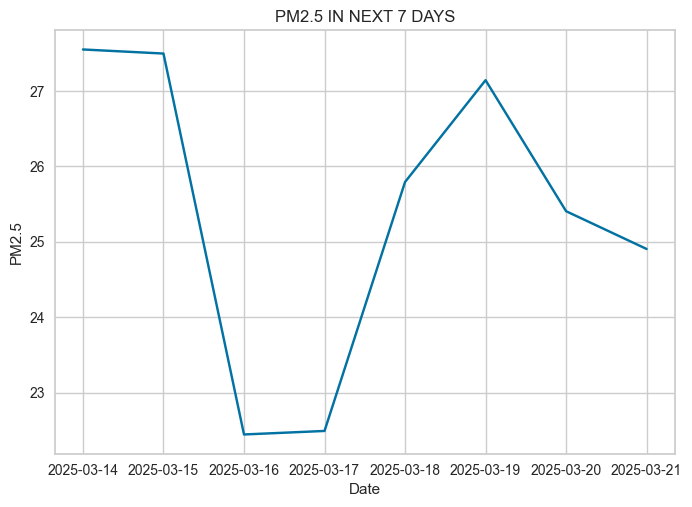

In [27]:
plt.plot(next_week, predict['prediction_label'])
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.title('PM2.5 IN NEXT 7 DAYS')
plt.grid(True)
plt.show()

In [28]:
save_model(ensem_best_model,'pm_2_5')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('date_feature_extractor',
                  TransformerWrapper(include=['timestamp'],
                                     transformer=ExtractDateTimeFeatures())),
                 ('numerical_imputer',
                  TransformerWrapper(include=['humidity', 'temperature'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('normalize', TransformerWrapper(transformer=StandardScaler())),
                 ('trained_model',
                  BaggingRegressor(estimator=LGBMRegressor(n_jobs=-1,
                                                           random_state=123),
                                   n_estimators=50, random_state=123))]),
 'pm_2_5.pkl')

In [29]:
predict_pm25 = pm_data
cleaned_file_path = ('D:\\7\\66-psu\\year2\\semester2\\ba ai\\termpro-predictPM25\\trainpredict_pm25.csv')
predict_pm25.to_csv(cleaned_file_path, index=False)